# Intro
This is a simple N-gram model that was tought to generate english names, similar to ones in the dataset

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing data

In [4]:
names_path = '/content/drive/MyDrive/PORTFOLIO/names_en.txt'

In [5]:
words = open(names_path, 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
num_char = sorted(['.'] + list(set(''.join(words))))

idx_to_letter = {num:char for num,char in enumerate(num_char)}
letter_to_idx = {char:num for num,char in enumerate(num_char)}

POWER = len(letter_to_idx)

print(POWER)

27


Creating a 3-gramms dataset

In [8]:
window_size = 3
X, Y = [], []
for word in words:
    word = '.' * window_size + word + '.'

    for i in range(0, len(word) - window_size):
        X.append([letter_to_idx[letter] for letter in word[i:i+window_size]])
        Y.append(letter_to_idx[word[i+window_size]])

X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
for x,y in zip(X[:10], Y[:10]):
    print(f'{x} ---> {y}')

tensor([0, 0, 0]) ---> 5
tensor([0, 0, 5]) ---> 13
tensor([ 0,  5, 13]) ---> 13
tensor([ 5, 13, 13]) ---> 1
tensor([13, 13,  1]) ---> 0
tensor([0, 0, 0]) ---> 15
tensor([ 0,  0, 15]) ---> 12
tensor([ 0, 15, 12]) ---> 9
tensor([15, 12,  9]) ---> 22
tensor([12,  9, 22]) ---> 9


In [10]:
X.shape

torch.Size([228146, 3])

In [11]:
device = 'cuda' if torch.cuda.is_available()  else 'cpu'
device

'cpu'

In [34]:
X = X.to(device)
Y = Y.to(device)

In [35]:
def train_test_split(data):
    l = len(data)
    return data[:int(len(data) * 0.8)], data[int(len(data) * 0.8):]

In [36]:
Xtr, Xte = train_test_split(X)
Ytr, Yte = train_test_split(Y)

In [37]:
Xtr, Xte = F.one_hot(Xtr).float(), F.one_hot(Xte).float()

In [38]:
Xtr[0]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Self written torch-like layers of neurons

In [39]:
class Linear:
    def __init__(self, in_features, out_features,  generator, device='cpu',bias=True):
        self.weights = torch.randn((in_features, out_features), generator=generator, device=device) / in_features**0.5 #dividing for saving tanh output from becoming zero
        self.bias = torch.zeros(out_features, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + [self.bias if self.bias is not None else []]

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, device='cpu'):
        self.eps = eps #won't let all break if the std equals zero
        self.momentum = momentum #precentage of new information arriving to the running mean
        self.training = True #True for training, False for evaluating (stops counting mean)

        #training parameters
        self.bn_scale = torch.ones(dim,device=device)
        self.bn_shift = torch.zeros(dim, device=device)

        #buffer values trained with running momentum
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self,x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        self.out = self.bn_scale * (x - xmean)/torch.sqrt(xvar + self.eps) + self.bn_shift

        return self.out

    def parameters(self):
        return [self.bn_scale, self.bn_shift]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []



In [40]:
Xtr.shape[0], Xte.shape[0]

(182516, 45630)

In [45]:
#embedding size
EMDIM = 32

#hidden units size
n_units = 100

g = torch.Generator(device=device).manual_seed(12345)

#embedding matrix
C = torch.randn((POWER, EMDIM), generator=g, device=device)

layers = [
    Linear(EMDIM * 3, n_units, generator=g, device=device),
    BatchNorm1d(n_units, device=device),
    Tanh(),
    Linear(n_units, n_units, generator=g, device=device),
    BatchNorm1d(n_units,device=device),
    Tanh(),
    Linear(n_units, n_units, generator=g, device=device),
    BatchNorm1d(n_units, device=device),
    Tanh(),
    Linear(n_units, n_units, generator=g, device=device),
    BatchNorm1d(n_units, device=device),
    Tanh(),
    Linear(n_units, POWER, generator=g, device=device),
]


with torch.no_grad():
    # make last layer less confident
    layers[-1].weights *= 0.1
    # apply gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print('Total params:', sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True


Total params: 44391


In [47]:
EPOCHS = 20000
BATCH = 64
loss_track = []
ud = []

for epoch in range(EPOCHS):
    #forward pass
    ixs = torch.randint(len(Xtr),(BATCH,),generator=g, device=device)

    Xb, Yb = Xtr[ixs], Ytr[ixs]

    out = (Xb @ C).view(-1, EMDIM * 3)
    for layer in layers:
        out = layer(out)

    #calculating the loss
    loss = F.cross_entropy(out, Yb)
    loss_track.append(loss)
    if epoch % 100 == 0:
        print(f'epoch: {epoch}, loss: {loss}')

    #zero grad
    for p in parameters:
        p.grad = None


    #backward pass
    loss.backward()

    #optimization step
    alpha = 0.1 if epoch < 10000 else 0.01
    for p in parameters:
        p.data += -alpha * p.grad




epoch: 0, loss: 3.3024299144744873
epoch: 100, loss: 2.6117920875549316
epoch: 200, loss: 2.476656436920166
epoch: 300, loss: 2.3012263774871826
epoch: 400, loss: 2.3104019165039062
epoch: 500, loss: 2.159017562866211
epoch: 600, loss: 2.3907132148742676
epoch: 700, loss: 2.359278440475464
epoch: 800, loss: 2.5946600437164307
epoch: 900, loss: 2.629537582397461
epoch: 1000, loss: 2.295013427734375
epoch: 1100, loss: 2.4196815490722656
epoch: 1200, loss: 2.2484302520751953
epoch: 1300, loss: 2.103701591491699
epoch: 1400, loss: 2.422646999359131
epoch: 1500, loss: 2.102501630783081
epoch: 1600, loss: 2.0555548667907715
epoch: 1700, loss: 2.188157796859741
epoch: 1800, loss: 2.411215305328369
epoch: 1900, loss: 2.2799224853515625
epoch: 2000, loss: 2.4989023208618164
epoch: 2100, loss: 2.0457727909088135
epoch: 2200, loss: 2.0367848873138428
epoch: 2300, loss: 2.1193253993988037
epoch: 2400, loss: 1.9764981269836426
epoch: 2500, loss: 2.47835111618042
epoch: 2600, loss: 2.312229394912719

In [49]:
#BatchNorm to test mode before evaluating model
for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

In [52]:
#evaluation
EPOCHS = 20000
BATCH = 64
test_loss_track = []

with torch.no_grad():
    for epoch in range(EPOCHS):
        #forward pass
        ixs = torch.randint(len(Xte),(BATCH,),generator=g, device=device)

        Xb, Yb = Xte[ixs], Yte[ixs]

        out = (Xb @ C).view(-1, EMDIM * 3)
        for layer in layers:
            out = layer(out)

        #calculating the loss
        loss = F.cross_entropy(out, Yb)
        test_loss_track.append(loss)
        if epoch % 100 == 0:
            print(f'epoch: {epoch}, loss: {loss}')



epoch: 0, loss: 2.2422752380371094
epoch: 100, loss: 2.2764205932617188
epoch: 200, loss: 2.4074132442474365
epoch: 300, loss: 2.2286741733551025
epoch: 400, loss: 2.61133074760437
epoch: 500, loss: 2.090020179748535
epoch: 600, loss: 2.3405656814575195
epoch: 700, loss: 2.3411495685577393
epoch: 800, loss: 2.2340803146362305
epoch: 900, loss: 2.4553511142730713
epoch: 1000, loss: 2.2506260871887207
epoch: 1100, loss: 2.3199868202209473
epoch: 1200, loss: 2.4637503623962402
epoch: 1300, loss: 2.1548123359680176
epoch: 1400, loss: 2.215266466140747
epoch: 1500, loss: 2.134615421295166
epoch: 1600, loss: 2.19753360748291
epoch: 1700, loss: 2.1447534561157227
epoch: 1800, loss: 2.4998323917388916
epoch: 1900, loss: 2.4372642040252686
epoch: 2000, loss: 2.4295475482940674
epoch: 2100, loss: 2.293205976486206
epoch: 2200, loss: 2.4395594596862793
epoch: 2300, loss: 2.511706829071045
epoch: 2400, loss: 2.1835570335388184
epoch: 2500, loss: 2.291844606399536
epoch: 2600, loss: 2.1702632904052

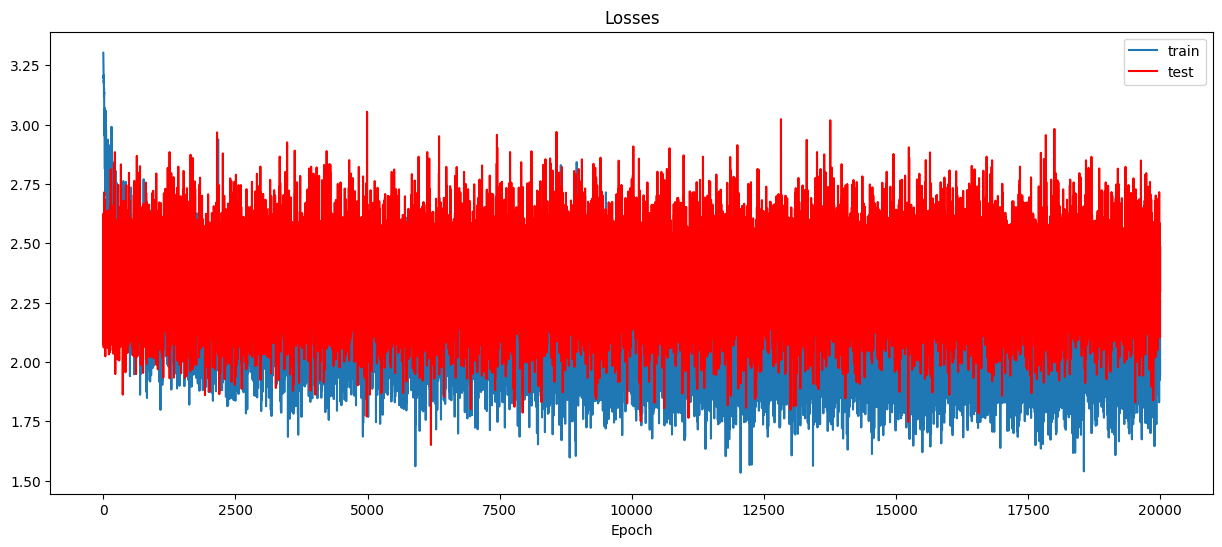

In [64]:
plt.figure(figsize=(15, 6))
plt.plot(list(range(len(loss_track))), [l.item() for l in loss_track])
plt.plot(list(range(len(test_loss_track))), [l.item() for l in test_loss_track], 'r')
plt.legend(['train','test'])
plt.grid(False)
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

## Generating names

In [83]:
#generating names
# g = torch.Generator(device=device).manual_seed(123123)

with torch.no_grad():
    for i in range(10):
        word = '...'
        while(1):
            idx = torch.tensor([letter_to_idx[l] for l in word[-3:]])
            idx_one_hot = F.one_hot(idx, num_classes=POWER).float().to(device)
            out = (idx_one_hot @ C).view(-1, 3*EMDIM)
            for layer in layers:
                out = layer(out)
            counts = out.exp()
            probs = counts/counts.sum(dim=1, keepdims=True)

            next_token_id = torch.multinomial(probs, 1, generator=g)
            word += idx_to_letter[next_token_id.item()]
            if next_token_id == 0:
                break
        print(word[3:-1])

tylia
lysenna
boj
tyliakynn
cayson
envi
saleah
ayen
mugri
namey
